# Development of a Medical Policy Extraction Algorithm

## Text extraction from a single pdf 

### Data Collection

**Import libraries**

In [1]:
import os
import re
import json
import time
import requests

from bs4 import BeautifulSoup
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd

import fitz  # PyMuPDF
import pdfplumber
from PyPDF2 import PdfReader

import openai
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from difflib import SequenceMatcher

**Fetching and downloading pdf from webpage**

In [2]:
# Fetch the webpage content
webpage_url = "https://www.hioscar.com/medical/cg013"
response = requests.get(webpage_url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract the iframe URL
iframe_tag = soup.find('iframe', {'class': 'EmbeddedAsset_iframe__157eM'})
if iframe_tag and 'src' in iframe_tag.attrs:
    pdf_url = iframe_tag['src']
    pdf_url = "https:" + pdf_url if pdf_url.startswith("//") else pdf_url
    print(f"Found PDF URL: {pdf_url}")
else:
    print("PDF URL not found.")

Found PDF URL: https://assets.ctfassets.net/plyq12u1bv8a/rV94yF13niNgBFNAhPxxu/54191136e83fce8fd4b9bd3106ad0504/CG013_Acupuncture.pdf


In [3]:
# Download PDF file
if pdf_url:
    pdf_response = requests.get(pdf_url)
    pdf_dir = "pdfs"
    os.makedirs(pdf_dir, exist_ok=True)
    pdf_filename = os.path.join(pdf_dir, 'Acupuncture_CG013.pdf')
    with open(pdf_filename, 'wb') as pdf_file:
        pdf_file.write(pdf_response.content)
    print(f"PDF downloaded and saved as: {pdf_filename}")
else:
    print("Failed to download the PDF as the URL was not found.")

PDF downloaded and saved as: pdfs/Acupuncture_CG013.pdf


### Data Visualization

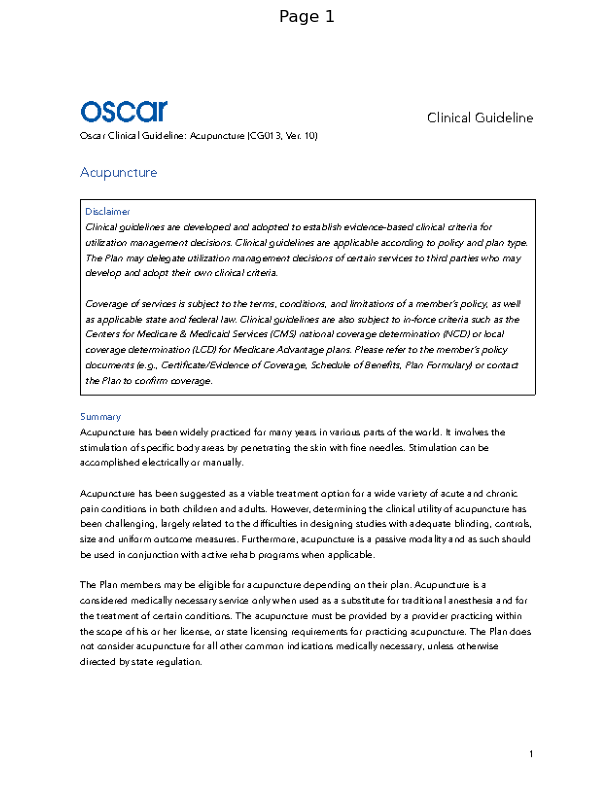

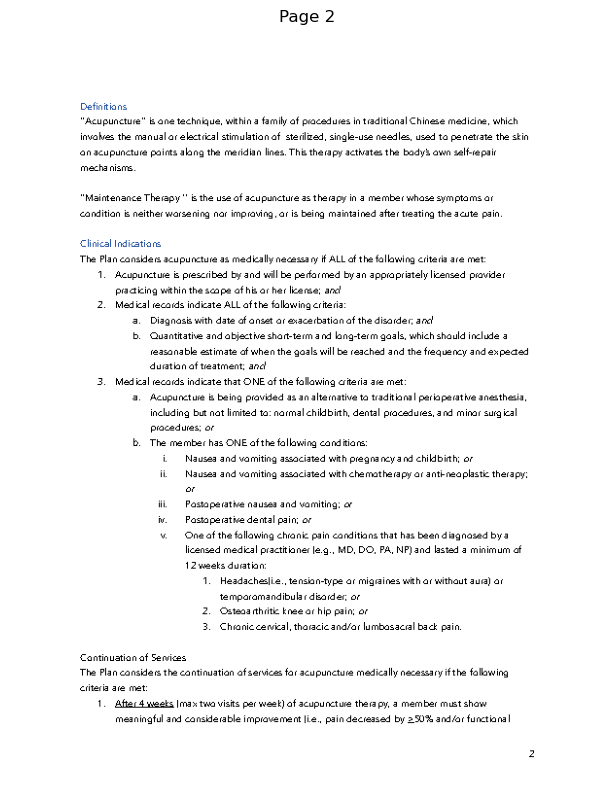

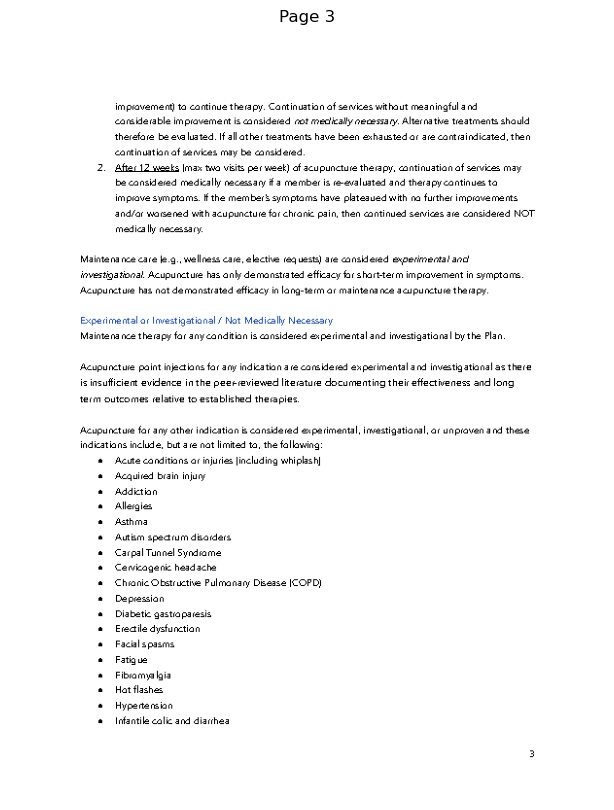

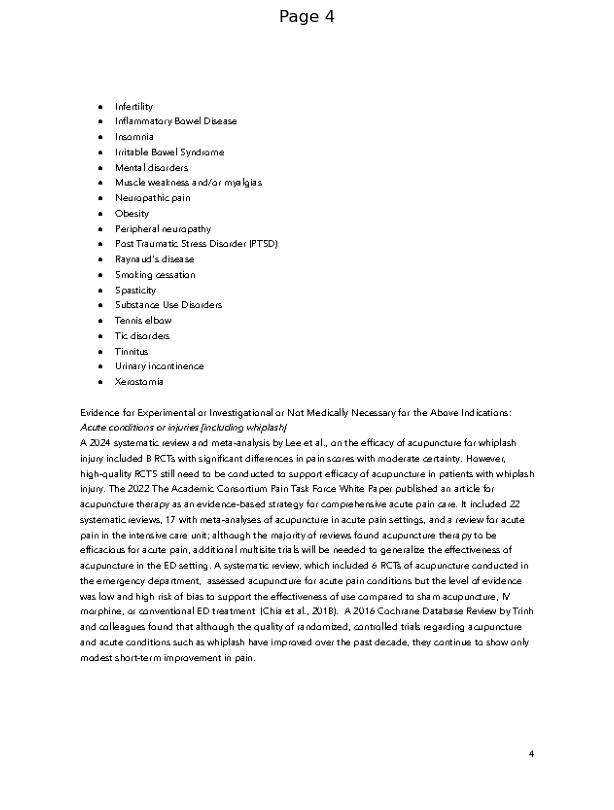

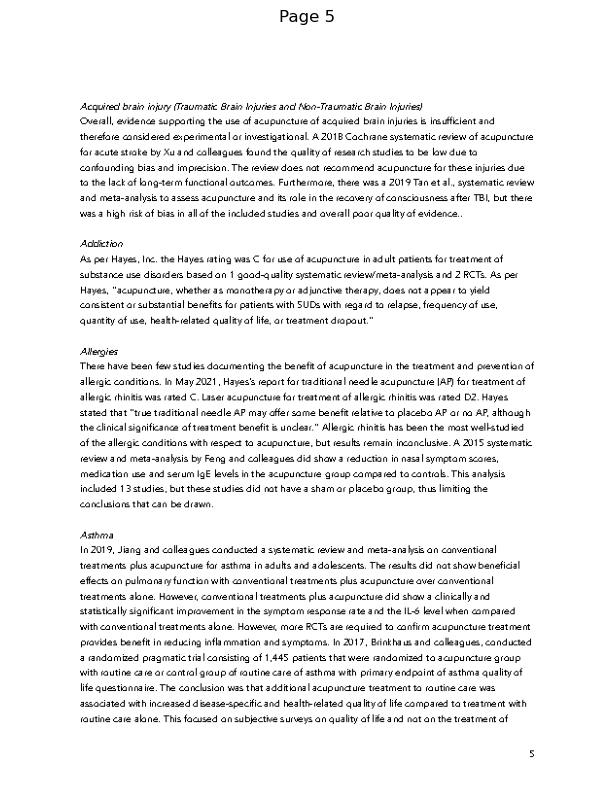

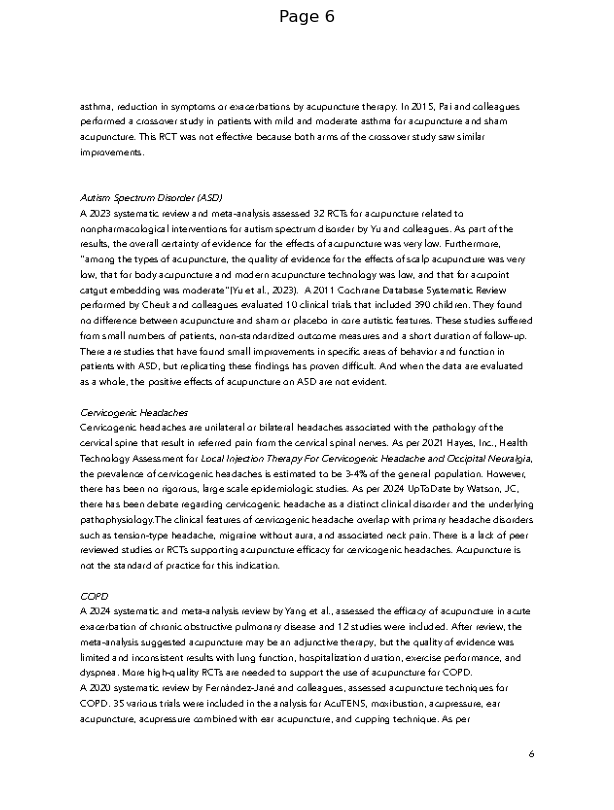

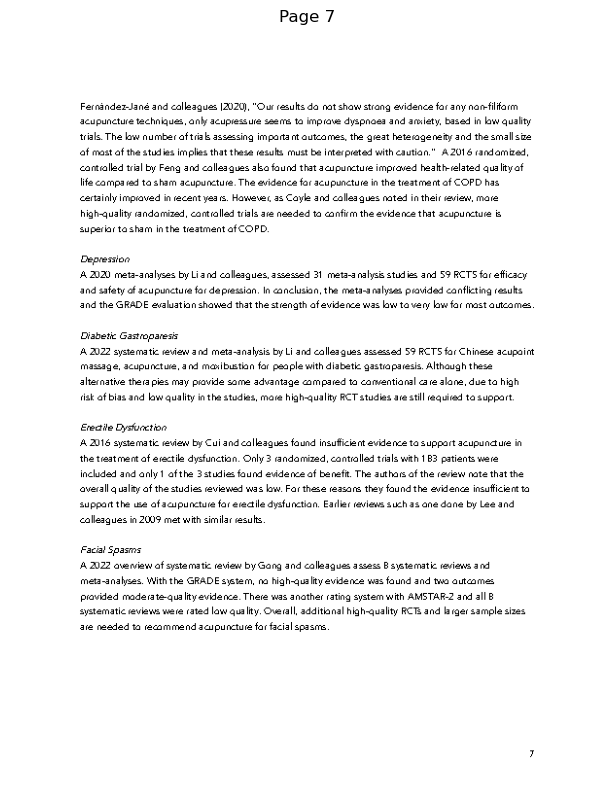

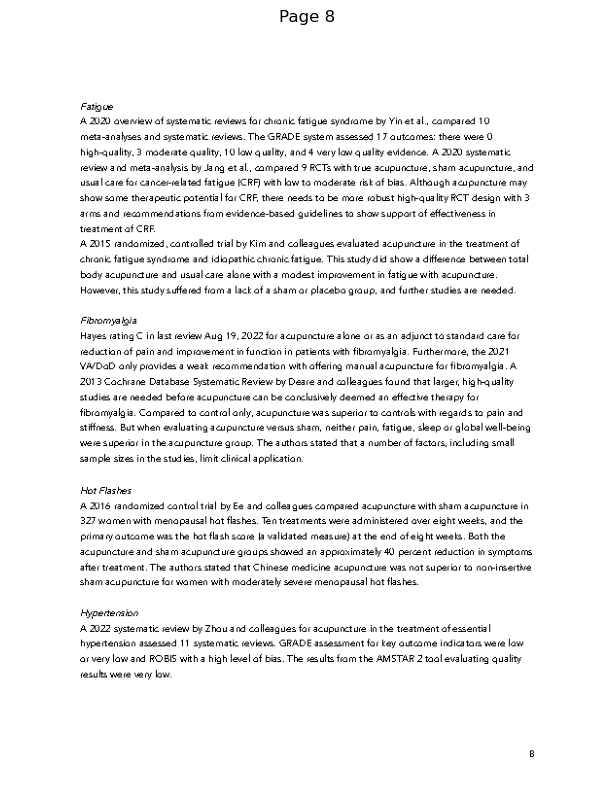

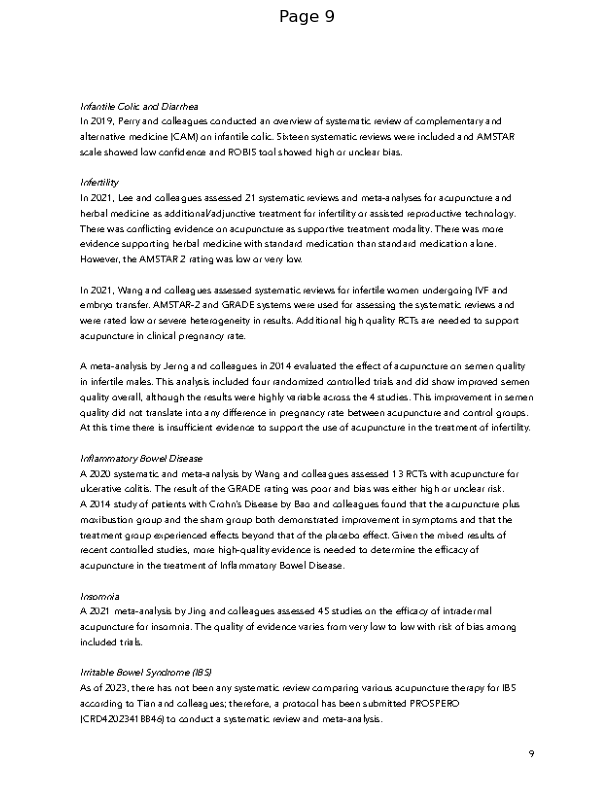

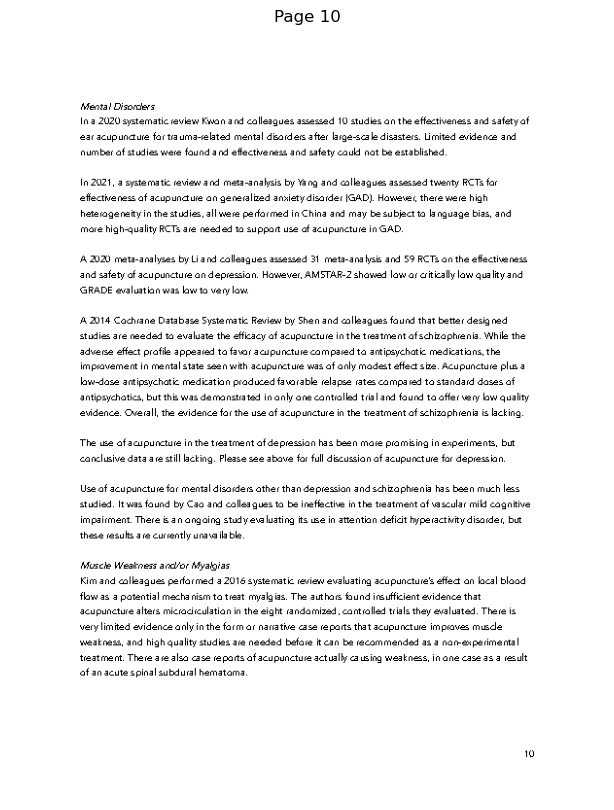

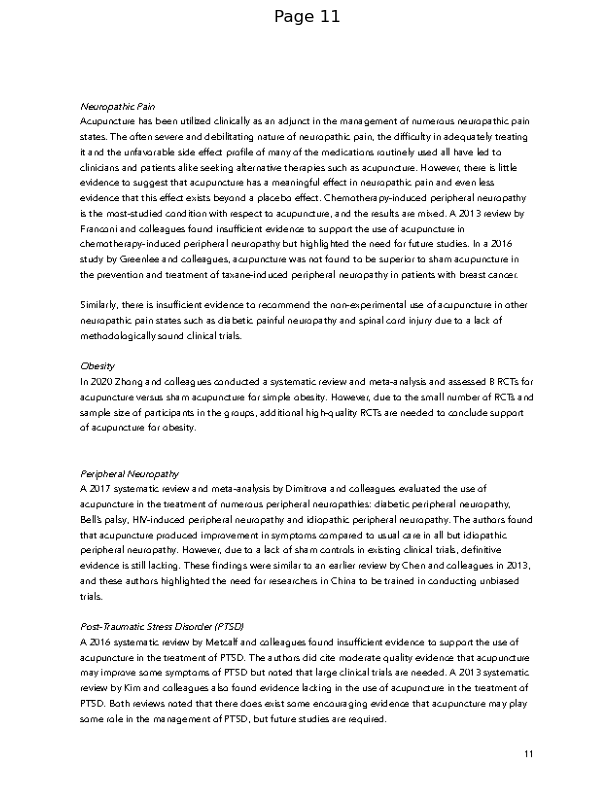

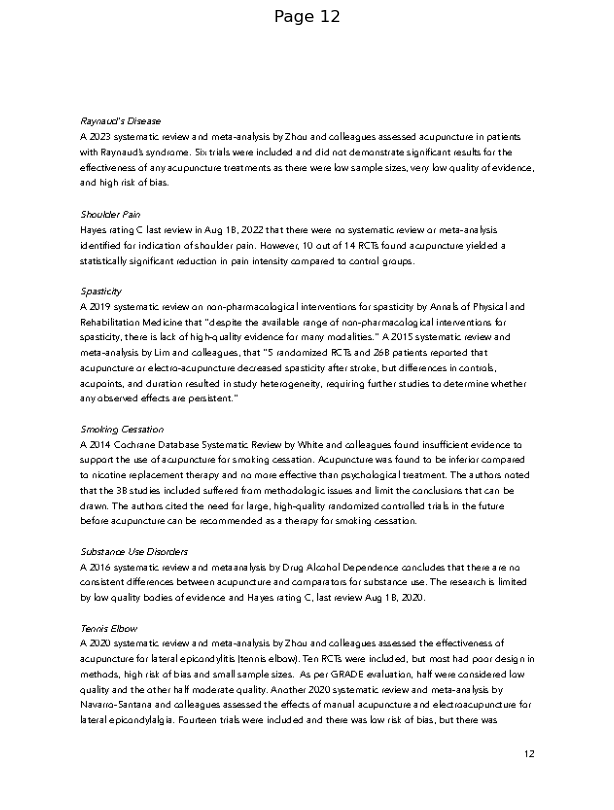

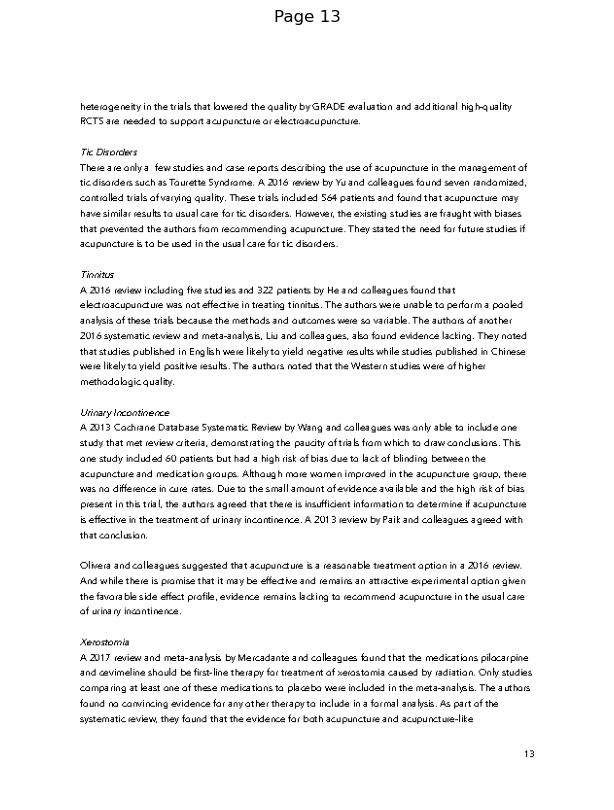

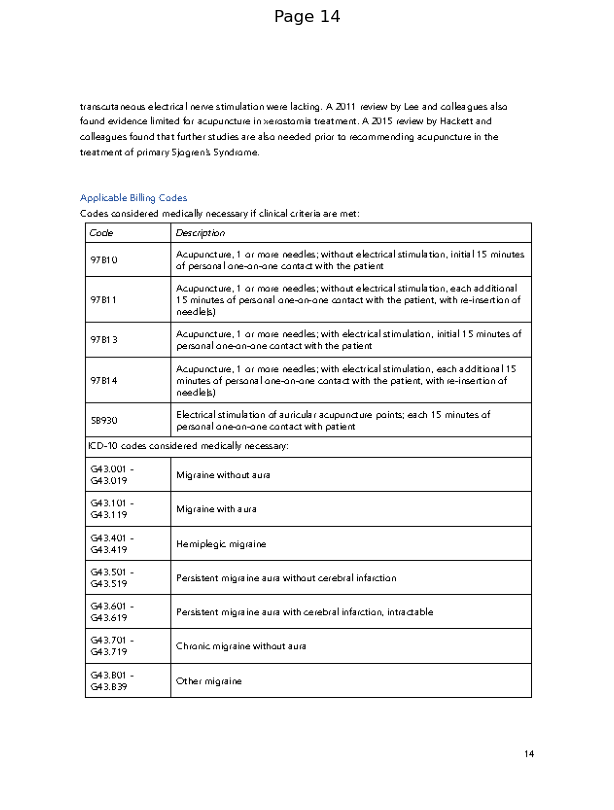

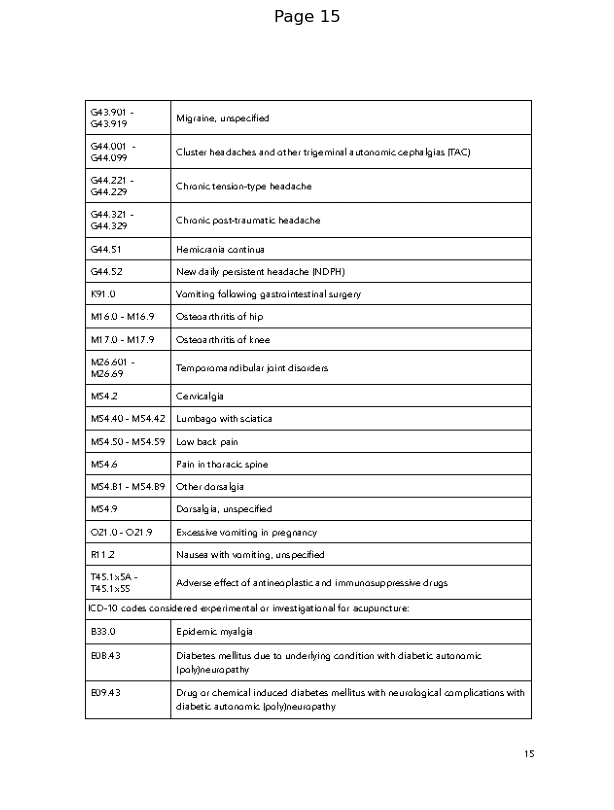

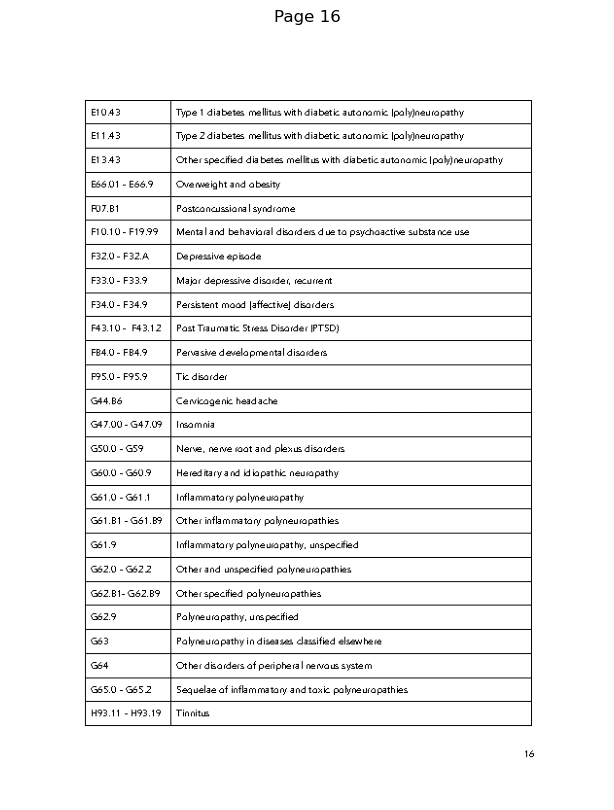

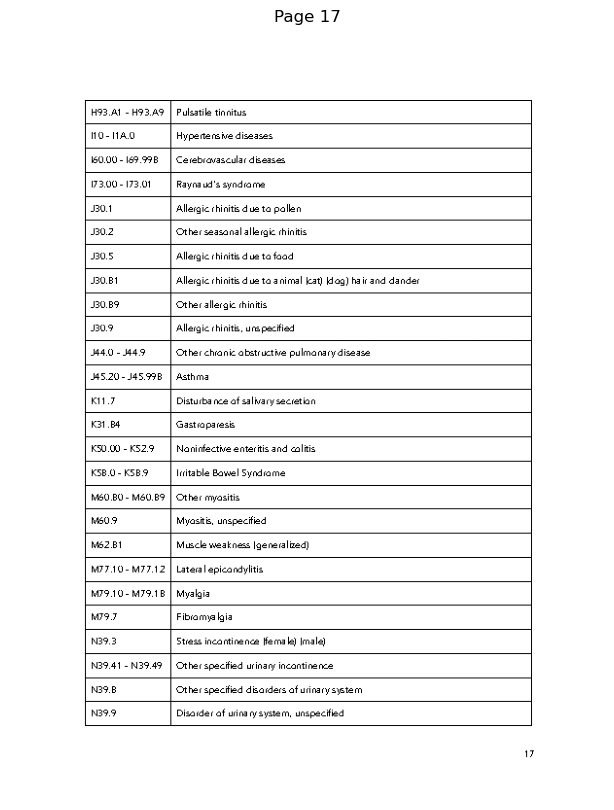

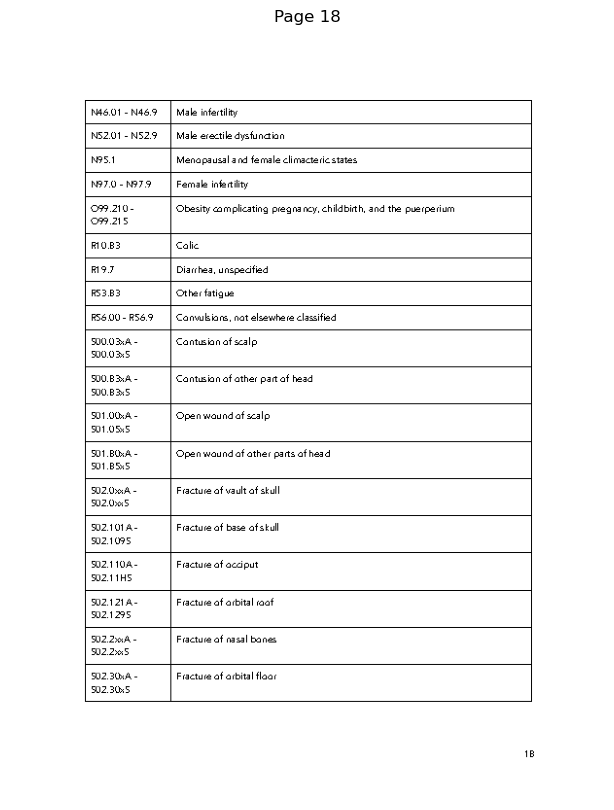

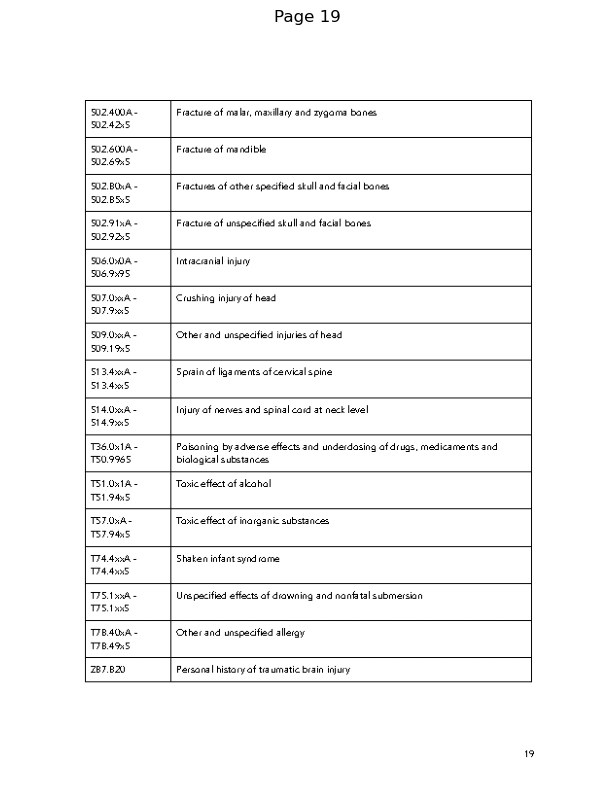

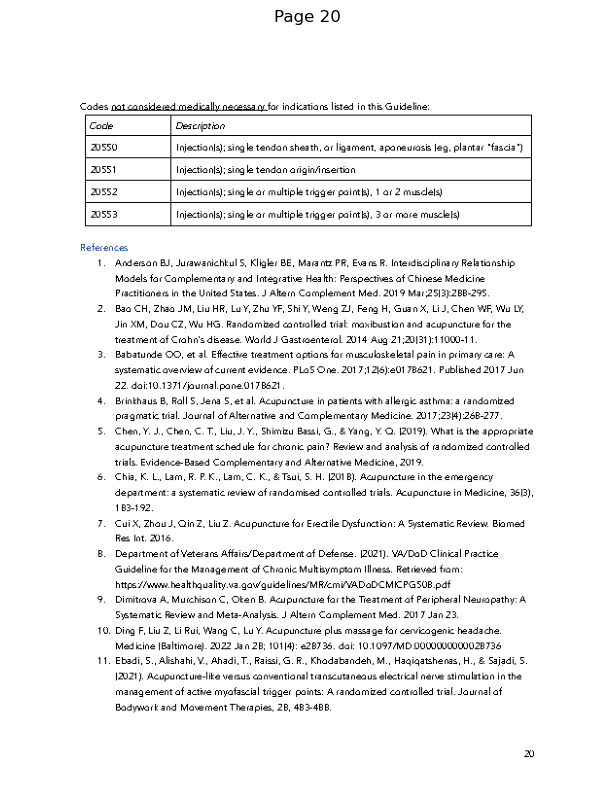

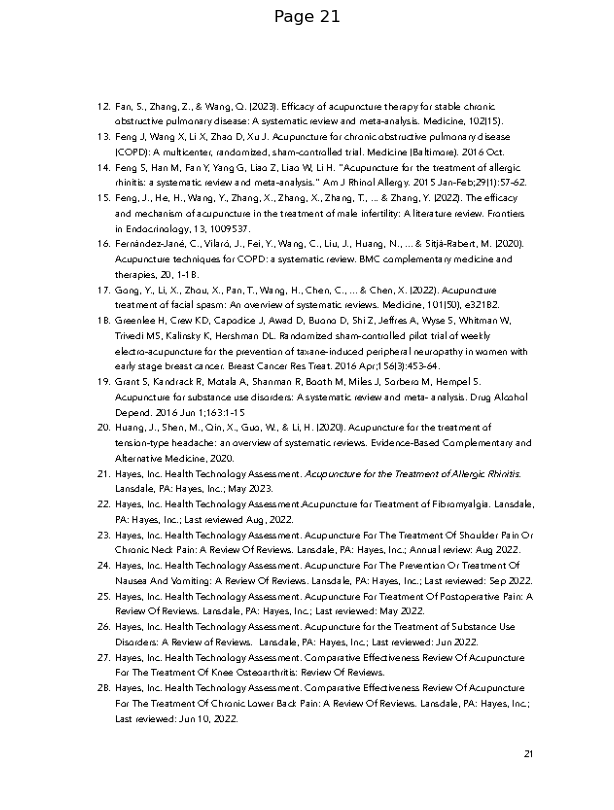

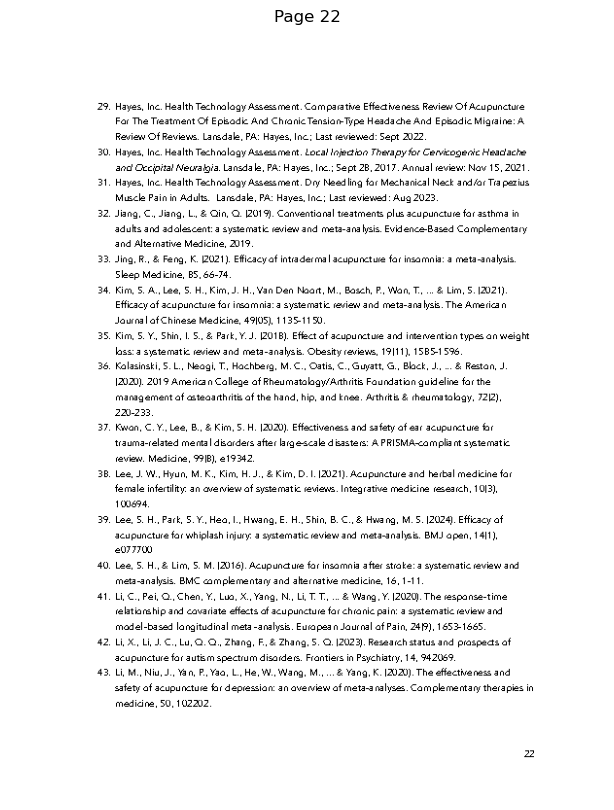

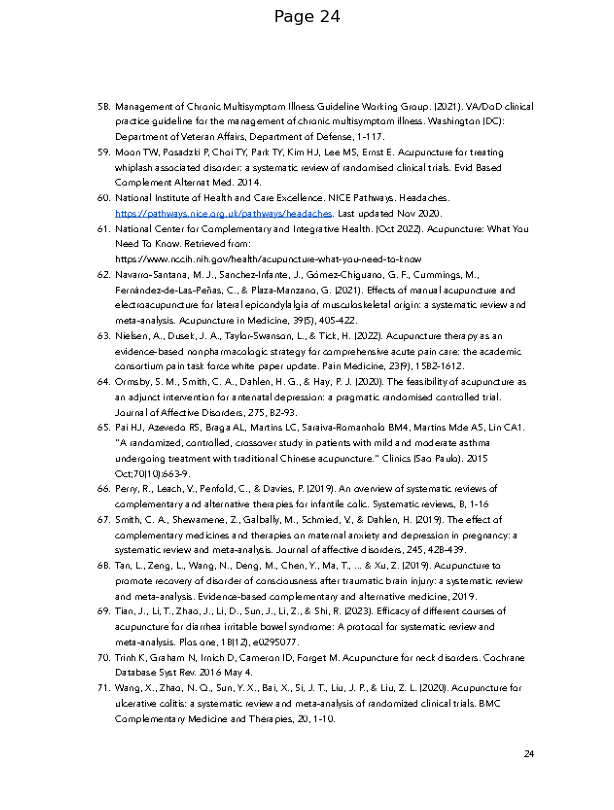

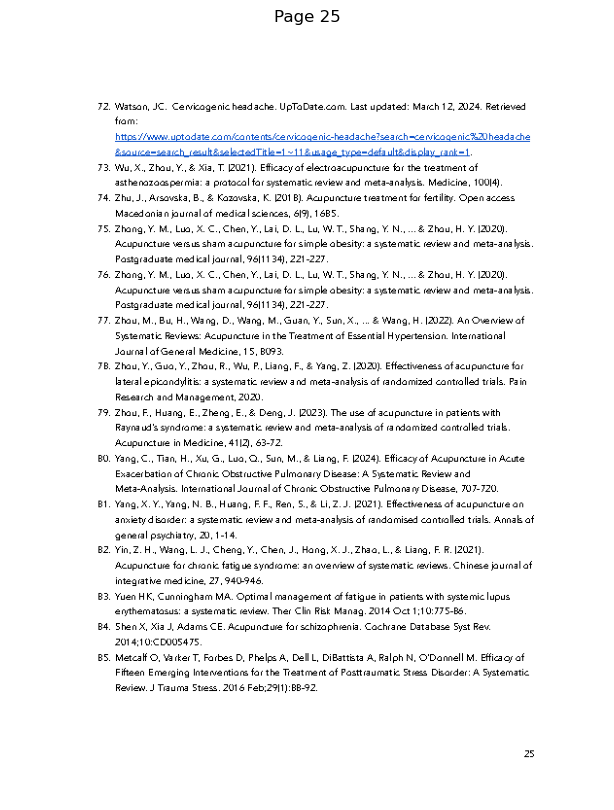

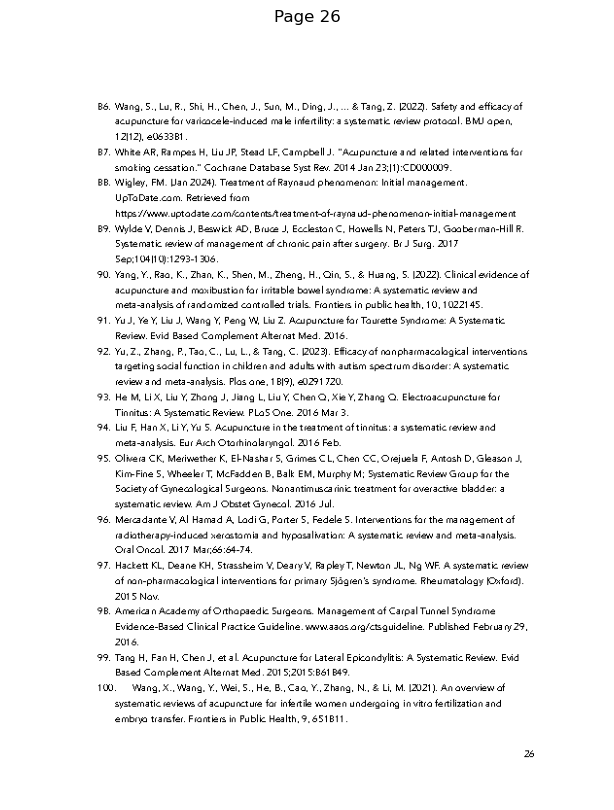

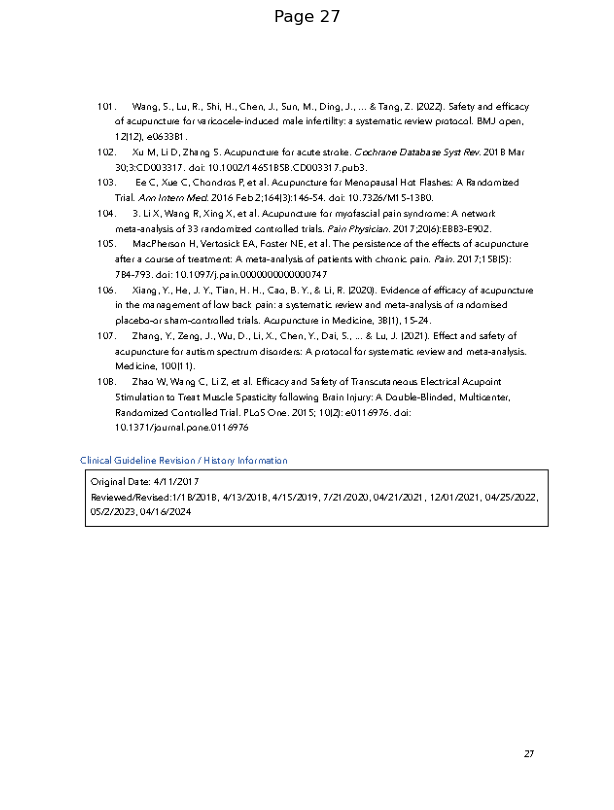

In [4]:
# View Text As Images
def render_pdf_as_images(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages):
            # Convert the page to an image
            image = page.to_image()
            # Display the image
            plt.figure(figsize=(10, 10))
            plt.imshow(image.original)
            plt.title(f'Page {i+1}')
            plt.axis('off')
            plt.show()

# Path to the downloaded PDF
pdf_path = os.path.join("pdfs", "Acupuncture_CG013.pdf")

# Render and display the PDF pages as images
render_pdf_as_images(pdf_path)

### Data Extraction and Standardization

**Data Extraction from single PDF**

In [5]:
# Function to extract text from the single PDF file
def extract_text_with_pymupdf(pdf_path):
    full_text = ""
    pdf_document = fitz.open(pdf_path)
    
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        text = page.get_text("text")
        full_text += text + "\n"
    
    return full_text

# Path to the downloaded PDF
pdf_path = os.path.join("pdfs", "Acupuncture_CG013.pdf")

# Extract the full text with PyMuPDF
pdf_text = extract_text_with_pymupdf(pdf_path)

# Save the extracted text to a file to inspect more easily 
with open("extracted_text_pymupdf.txt", "w") as text_file:
    text_file.write(pdf_text)

# Print the first 2000 characters to see the improvement
print(pdf_text[:2000])

Clinical Guideline
Oscar Clinical Guideline: Acupuncture (CG013, Ver. 10)
Acupuncture
Disclaimer
Clinical guidelines are developed and adopted to establish evidence-based clinical criteria for
utilization management decisions. Clinical guidelines are applicable according to policy and plan type.
The Plan may delegate utilization management decisions of certain services to third parties who may
develop and adopt their own clinical criteria.
Coverage of services is subject to the terms, conditions, and limitations of a member’s policy, as well
as applicable state and federal law. Clinical guidelines are also subject to in-force criteria such as the
Centers for Medicare & Medicaid Services (CMS) national coverage determination (NCD) or local
coverage determination (LCD) for Medicare Advantage plans. Please refer to the member’s policy
documents (e.g., Certificate/Evidence of Coverage, Schedule of Benefits, Plan Formulary) or contact
the Plan to confirm coverage.
Summary
Acupuncture has be

In [6]:
# Function to extract the "Clinical Indications" section
def extract_clinical_indications(text):
    start_keyword = "Clinical Indications"
    end_keyword = "Continuation of Services"
    
    start_idx = text.find(start_keyword)
    end_idx = text.find(end_keyword)
    
    if start_idx != -1 and end_idx != -1:
        return text[start_idx:end_idx].strip()
    else:
        return "Failed to extract 'Clinical Indications' section."

# Extract the "Clinical Indications" section
clinical_indications = extract_clinical_indications(pdf_text)

# Save the extracted section to a file to inspect more easily 
with open("clinical_indications.txt", "w") as text_file:
    text_file.write(clinical_indications)

# Print the extracted "Clinical Indications" section
print(clinical_indications)

Clinical Indications
The Plan considers acupuncture as medically necessary if ALL of the following criteria are met:
1.
Acupuncture is prescribed by and will be performed by an appropriately licensed provider
practicing within the scope of his or her license; and
2.
Medical records indicate ALL of the following criteria:
a.
Diagnosis with date of onset or exacerbation of the disorder; and
b.
Quantitative and objective short-term and long-term goals, which should include a
reasonable estimate of when the goals will be reached and the frequency and expected
duration of treatment; and
3.
Medical records indicate that ONE of the following criteria are met:
a.
Acupuncture is being provided as an alternative to traditional perioperative anesthesia,
including but not limited to: normal childbirth, dental procedures, and minor surgical
procedures; or
b.
The member has ONE of the following conditions:
i.
Nausea and vomiting associated with pregnancy and childbirth; or
ii.
Nausea and vomiting as

**Process and standardize PDF data**

In [7]:
# Create a standardized format
standardized_entry = {
    "pdf_file": os.path.basename(pdf_path),
    "clinical_indications": clinical_indications
}

# Save the standardized data to a JSON file
standardized_data = [standardized_entry]
with open('standardized_clinical_indications_single.json', 'w') as json_file:
    json.dump(standardized_data, json_file, indent=4)

print("Standardized data has been saved to 'standardized_clinical_indications_single.json'")

Standardized data has been saved to 'standardized_clinical_indications_single.json'


**Convert JSON Data to a Structured DataFrame**

In [8]:
# Function to read JSON and convert it to a structured format
def read_json(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

# Function to parse the clinical indications section into a structured format
def parse_clinical_indications(clinical_indications):
    # Split the clinical indications by criteria numbers 
    parsed_data = []
    lines = clinical_indications.split('\n')
    current_section = []
    for line in lines:
        if line.strip().isdigit() or line.strip().split()[0].isdigit():
            if current_section:
                parsed_data.append(' '.join(current_section).strip())
            current_section = [line]
        else:
            current_section.append(line)
    if current_section:
        parsed_data.append(' '.join(current_section).strip())
    return parsed_data

# Function to convert the structured data into a DataFrame
def create_dataframe(data):
    df_data = []
    for entry in data:
        pdf_file = entry['pdf_file']
        clinical_indications = entry['clinical_indications']
        parsed_indications = parse_clinical_indications(clinical_indications)
        for indication in parsed_indications:
            df_data.append({'PDF File': pdf_file, 'Clinical Indications': indication})
    df = pd.DataFrame(df_data)
    return df

# Path to the JSON file
json_file_path = 'standardized_clinical_indications_single.json'

# Read and parse the JSON data
data = read_json(json_file_path)

# Create a DataFrame
df = create_dataframe(data)

# Display the DataFrame
print(df)

# Save the DataFrame to a CSV file for easier access and readability
df.to_csv('clinical_indications_single.csv', index=False)

                PDF File                               Clinical Indications
0  Acupuncture_CG013.pdf  Clinical Indications The Plan considers acupun...
1  Acupuncture_CG013.pdf  12 weeks duration: 1. Headaches(i.e., tension-...


**Display DataFrame and Save to Excel**

In [9]:
pd.set_option('display.max_colwidth', None)  # Ensure text does not get truncated
pd.set_option('display.expand_frame_repr', False)  # Ensure DataFrame does not get wrapped

# Display the DataFrame
display(df)

# Save to Excel for better readability if needed
df.to_excel('clinical_indications_single.xlsx', index=False)

PDF File                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Clinical Indications
0  Acupuncture_CG013.pdf  Clinical Indications The Plan considers acupuncture as medically necessary if ALL of the following criteria are met: 1. Acupuncture is prescribed by and will be performed by an appropriately licensed provider practicing within the scope of his or her license; and 2. Medical records indicate ALL of the following criteria: a. Diagnosis with date of onset or exacerbation of the disorder; and b. Quantitative and objective short-term and long-term goals, which should include a reasonable estimate of when the goals will be reached and the frequency and expected duration of treatment; and 3. Medical records indicate that ONE of the following criteria are met: a. Acupuncture is being provided as an alternative to traditional perioperative anesthesia, including but not limited to: normal childbirth, dental procedures, and minor surgical procedures; or b. The member has ONE of the following conditions: i. Nausea and vomiting associated with pregnancy and childbirth; or ii. Nausea and vomiting associated with chemotherapy or anti-neoplastic therapy; or iii. Postoperative nausea and vomiting; or iv. Postoperative dental pain; or v. One of the following chronic pain conditions that has been diagnosed by a licensed medical practitioner (e.g., MD, DO, PA, NP) and lasted a minimum of
1  Acupuncture_CG013.pdf                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                12 weeks duration: 1. Headaches(i.e., tension-type or migraines with or without aura) or temporomandibular disorder; or 2. Osteoarthritic knee or hip pain; or 3. Chronic cervical, thoracic and/or lumbosacral back pain.

## Text extraction from multiple pdfs

### Data Collection

**Fetching all links from the Oscar webpage** 

In [10]:
def get_links(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        a_tags = soup.find_all('a')
        links = [a.get('href') for a in a_tags if a.get('href')]
        return links
    else:
        return []

url = 'https://www.hioscar.com/clinical-guidelines/medical'
all_links = get_links(url)
print(all_links)

['#mainContent', 'tel:1-855-672-2788', '/', '/care-options', 'https://www.hioscar.com/clinical-guidelines/pharmacy', '/medical/cg013', '/pg139', '/medical/cg059', '/medical/cg032', '/medical/cg057', '/medical/cg041', '/pharmacy/pg136', '/pharmacy/pg158', '/medical/cg026', '/medical/cg018', '/medical/cg008', '/medical/cg009', '/pharmacy/pg180', '/medical/cg030', '/medical/cg033', '/medical/cg031', '/medical/cg027', '/medical/cg036', '/medical/cg002', '/pharmacy/pg134', '/cg113', '/cg067', '/pharmacy/pg141', '/medical/cg024', '/cg052py23', '/py24cg052', '/cg086', '/cg083', '/cg088', '/cg098', '/cg084', '/cg091', '/cg090', '/cg089', '/cg092', '/cg093', '/cg085', '/cg094', '/cg100', '/cg087', '/cg107', '/cg079', '/cg095', '/cg096', '/cg097', '/cg081', '/cg080', '/cg078', '/cg082', '/cg099', '/medical/cg064', '/medical/cg039', '/medical/cg077', '/medical/cg050', '/medical/cg028', '/cg116', '/pharmacy/pg160', '/medical/cg037', '/medical/cg011', '/medical/cg012', '/medical/cg034', '/medical/c

**Filter and Processing Links**

In [11]:
# Filter the links to keep only those that start with 'https://www.hioscar.com/medical/'
filtered_links = [link for link in all_links if link.startswith('/medical/')]

# Prepend the base URL to each filtered link
base_url = 'https://www.hioscar.com'
filtered_links = [base_url + link for link in filtered_links]

print(filtered_links)

['https://www.hioscar.com/medical/cg013', 'https://www.hioscar.com/medical/cg059', 'https://www.hioscar.com/medical/cg032', 'https://www.hioscar.com/medical/cg057', 'https://www.hioscar.com/medical/cg041', 'https://www.hioscar.com/medical/cg026', 'https://www.hioscar.com/medical/cg018', 'https://www.hioscar.com/medical/cg008', 'https://www.hioscar.com/medical/cg009', 'https://www.hioscar.com/medical/cg030', 'https://www.hioscar.com/medical/cg033', 'https://www.hioscar.com/medical/cg031', 'https://www.hioscar.com/medical/cg027', 'https://www.hioscar.com/medical/cg036', 'https://www.hioscar.com/medical/cg002', 'https://www.hioscar.com/medical/cg024', 'https://www.hioscar.com/medical/cg064', 'https://www.hioscar.com/medical/cg039', 'https://www.hioscar.com/medical/cg077', 'https://www.hioscar.com/medical/cg050', 'https://www.hioscar.com/medical/cg028', 'https://www.hioscar.com/medical/cg037', 'https://www.hioscar.com/medical/cg011', 'https://www.hioscar.com/medical/cg012', 'https://www.hi

**Fetch, Extract, and Download PDF URLs** 

In [12]:
# Function to extract text from a PDF using PyMuPDF
def extract_text_with_pymupdf(pdf_path):
    full_text = ""
    pdf_document = fitz.open(pdf_path)
    
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        text = page.get_text("text")
        full_text += text + "\n"
    
    return full_text

# Function to extract the "Clinical Indications" section from text
def extract_clinical_indications(text):
    start_keyword = "Clinical Indications"
    end_keyword = "Continuation of Services"
    
    start_idx = text.find(start_keyword)
    end_idx = text.find(end_keyword)
    
    if start_idx != -1 and end_idx != -1:
        return text[start_idx:end_idx].strip()
    else:
        return "Failed to extract 'Clinical Indications' section."

# URLs for different medical guidelines, hardcoding a few just to test performance
urls = [
    "https://www.hioscar.com/medical/cg013",
    "https://www.hioscar.com/medical/cg015",
    "https://www.hioscar.com/medical/cg017"
]

pdf_dir = "pdfs"
os.makedirs(pdf_dir, exist_ok=True)

pdf_counter = 1

for webpage_url in urls:
    # Fetch webpage content
    response = requests.get(webpage_url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract all iframe URLs containing PDFs
    iframe_tags = soup.find_all('iframe', {'class': 'EmbeddedAsset_iframe__157eM'})
    pdf_urls = []

    for iframe_tag in iframe_tags:
        if iframe_tag and 'src' in iframe_tag.attrs:
            pdf_url = iframe_tag['src']
            pdf_url = "https:" + pdf_url if pdf_url.startswith("//") else pdf_url
            pdf_urls.append(pdf_url)

    # Download each PDF and extract "Clinical Indications" section
    for pdf_url in pdf_urls:
        pdf_response = requests.get(pdf_url)
        pdf_filename = os.path.join(pdf_dir, f'document_{pdf_counter}.pdf')
        
        with open(pdf_filename, 'wb') as pdf_file:
            pdf_file.write(pdf_response.content)
        
        print(f"PDF {pdf_counter} downloaded and saved as: {pdf_filename}")

        # Extract text from PDF
        pdf_text = extract_text_with_pymupdf(pdf_filename)

        # Extract "Clinical Indications" section
        clinical_indications = extract_clinical_indications(pdf_text)

        # Save extracted section to a file to inpect more easily 
        with open(f"clinical_indications_{pdf_counter}.txt", "w") as text_file:
            text_file.write(clinical_indications)

        # Print extracted "Clinical Indications" section
        print(f"Clinical Indications from document {pdf_counter}:\n")
        print(clinical_indications)
        print("\n" + "="*80 + "\n")

        pdf_counter += 1


PDF 1 downloaded and saved as: pdfs/document_1.pdf
Clinical Indications from document 1:

Clinical Indications
The Plan considers acupuncture as medically necessary if ALL of the following criteria are met:
1.
Acupuncture is prescribed by and will be performed by an appropriately licensed provider
practicing within the scope of his or her license; and
2.
Medical records indicate ALL of the following criteria:
a.
Diagnosis with date of onset or exacerbation of the disorder; and
b.
Quantitative and objective short-term and long-term goals, which should include a
reasonable estimate of when the goals will be reached and the frequency and expected
duration of treatment; and
3.
Medical records indicate that ONE of the following criteria are met:
a.
Acupuncture is being provided as an alternative to traditional perioperative anesthesia,
including but not limited to: normal childbirth, dental procedures, and minor surgical
procedures; or
b.
The member has ONE of the following conditions:
i.
N

In [13]:
# List to store extracted PDF URLs
pdf_urls_list = []

# Function to fetch and extract the PDF URLs from the given list of filtered links
def fetch_pdf_url(webpage_url):
    response = requests.get(webpage_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    iframe_tag = soup.find('iframe', {'class': 'EmbeddedAsset_iframe__157eM'})
    if iframe_tag and 'src' in iframe_tag.attrs:
        pdf_url = iframe_tag['src']
        pdf_url = "https:" + pdf_url if pdf_url.startswith("//") else pdf_url
        return pdf_url
    else:
        return None

# Extract PDF URLs for all filtered links and add them to the pdf_urls_list
pdf_urls = {}
for link in filtered_links:
    pdf_url = fetch_pdf_url(link)
    if pdf_url:
        pdf_urls[link] = pdf_url
        pdf_urls_list.append(pdf_url)

# Print extracted PDF URLs to verify
for link, pdf_url in pdf_urls.items():
    print(f"Webpage URL: {link}")
    print(f"PDF URL: {pdf_url}")
    print("-" * 80)

# Download PDFs using the pdf_urls_list
pdf_dir = "pdfs"
os.makedirs(pdf_dir, exist_ok=True)

for pdf_url in pdf_urls_list:
    response = requests.get(pdf_url)
    pdf_filename = os.path.join(pdf_dir, os.path.basename(pdf_url))
    with open(pdf_filename, 'wb') as pdf_file:
        pdf_file.write(response.content)
    print(f"Downloaded and saved PDF: {pdf_filename}")

Webpage URL: https://www.hioscar.com/medical/cg013
PDF URL: https://assets.ctfassets.net/plyq12u1bv8a/rV94yF13niNgBFNAhPxxu/54191136e83fce8fd4b9bd3106ad0504/CG013_Acupuncture.pdf
--------------------------------------------------------------------------------
Webpage URL: https://www.hioscar.com/medical/cg059
PDF URL: https://assets.ctfassets.net/plyq12u1bv8a/3hVd5ozdVHhuviEo8naNYN/5d169efaba05855625d77d49e7782cd5/CG059_Allergy_Immunotherapy.pdf
--------------------------------------------------------------------------------
Webpage URL: https://www.hioscar.com/medical/cg032
PDF URL: https://assets.ctfassets.net/plyq12u1bv8a/Wuh2wfC1GGts428R3zRP1/3b9aadf91aecab359ef3284a9d73566c/CG032_Ambulatory_Cardiac_Event_Monitoring.pdf
--------------------------------------------------------------------------------
Webpage URL: https://www.hioscar.com/medical/cg057
PDF URL: https://assets.ctfassets.net/plyq12u1bv8a/3OnU1EAUmcXXfp1s3tUG0O/5f2b1b5b00ac6a6c35a4f3f541cfb75a/CG057_Ambulance_Services.pd

### Data Extraction

**Processing Downloaded PDFs**

In [14]:
# Directory to save PDFs
pdf_dir = "pdfs"

# Get list of downloaded PDFs
pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith('.pdf')]

# Check file sizes
for pdf_file in pdf_files:
    file_path = os.path.join(pdf_dir, pdf_file)
    file_size = os.path.getsize(file_path)
    print(f"{pdf_file}: {file_size} bytes")

# Function to extract text from a PDF
def extract_text_from_pdf(pdf_path):
    try:
        reader = PdfReader(pdf_path)
        text = ''
        for page in reader.pages:
            text += page.extract_text()
        return text
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
        return None

# Extract text from a few PDFs and print the first 500 characters
sample_files = pdf_files[:5]  
for pdf_file in sample_files:
    file_path = os.path.join(pdf_dir, pdf_file)
    print(f"Extracting text from: {pdf_file}")
    text = extract_text_from_pdf(file_path)
    if text:
        print(text[:500])  
        print("-" * 80)

CG041_Anesthesia_and_Sedation_in_Endoscopic_Procedures.pdf: 138425 bytes
CG037_Erectile_Dysfunction.pdf: 154491 bytes
CG051_Spinal_Orthoses__Back_Braces_.pdf: 176926 bytes
CG047_Pain_Management__Facet_Joint_Injections_Medial_Branch_Blocks_and_Radiofrequency_Facet_Denervation.pdf: 178003 bytes
CG011_Enteral_and_Oral_Nutritional_Supplements.pdf: 425932 bytes
CG007_Pressure_Reducing_Support_Surfaces__1_.pdf: 137889 bytes
CG048_Pain_Management__Epidural_Steroid_Injections__Selective_Nerve_Root_Block__SNRB___and_Intradiscal_Steroid_Injections.pdf: 180913 bytes
CG032_Ambulatory_Cardiac_Event_Monitoring.pdf: 171997 bytes
CG044_Outpatient_Physical_Therapy___Occupational_Therapy.pdf: 201474 bytes
CG022_Home_Care_-_Home_Health_Aides.pdf: 111029 bytes
CG010_Medical_Nutrition_Therapy.pdf: 153015 bytes
CG027_Breast_Imaging.pdf: 114099 bytes
CG008_Bariatric_Surgery__Adults_.pdf: 220480 bytes
CG036_Breast_Procedures.pdf: 223663 bytes
CG028_Diabetes_Equipment_and_Supplies.pdf: 202283 bytes
CG001_Heari

**Extracting "Clinical Indications" Section**

In [15]:
# Function to extract "Clinical Indications" section
def extract_clinical_indications(text):
    start_keyword = "Clinical Indications"
    end_keyword = "Continuation of Services"
    
    start_idx = text.find(start_keyword)
    end_idx = text.find(end_keyword)
    
    if start_idx != -1 and end_idx != -1:
        return text[start_idx:end_idx].strip()
    else:
        return "Failed to extract 'Clinical Indications' section."

# Directory containing PDFs
pdf_dir = "pdfs"
output_dir = "clinical_indications_texts"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop through each PDF in the directory
for pdf_file in os.listdir(pdf_dir):
    if pdf_file.endswith(".pdf"):
        pdf_path = os.path.join(pdf_dir, pdf_file)
        pdf_text = extract_text_from_pdf(pdf_path)
        
        # Extract "Clinical Indications" section
        clinical_indications = extract_clinical_indications(pdf_text)
        
        # Save extracted section to a file to inspect more easily 
        output_file_path = os.path.join(output_dir, f"{os.path.splitext(pdf_file)[0]}_clinical_indications.txt")
        with open(output_file_path, "w") as text_file:
            text_file.write(clinical_indications)
        
        # Print extracted "Clinical Indications" section
        print(f"Extracted 'Clinical Indications' from {pdf_file}")
        print(clinical_indications)
        print("-" * 80)

Extracted 'Clinical Indications' from CG041_Anesthesia_and_Sedation_in_Endoscopic_Procedures.pdf
Failed to extract 'Clinical Indications' section.
--------------------------------------------------------------------------------
Extracted 'Clinical Indications' from CG037_Erectile_Dysfunction.pdf
Failed to extract 'Clinical Indications' section.
--------------------------------------------------------------------------------
Extracted 'Clinical Indications' from CG051_Spinal_Orthoses__Back_Braces_.pdf
Failed to extract 'Clinical Indications' section.
--------------------------------------------------------------------------------
Extracted 'Clinical Indications' from CG047_Pain_Management__Facet_Joint_Injections_Medial_Branch_Blocks_and_Radiofrequency_Facet_Denervation.pdf
Failed to extract 'Clinical Indications' section.
--------------------------------------------------------------------------------
Extracted 'Clinical Indications' from CG011_Enteral_and_Oral_Nutritional_Supplements.p

As we can see from the results of the previous block of code, we need to take additional steps to extract the "Clinical Indications" section effectively

**Extracting and Saving "Clinical Indications" Section with Enhanced Keyword Matching**

In [16]:
# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

# Function to extract the "Clinical Indications" section
def extract_clinical_indications(text):
    start_keywords = ["Clinical Indications", "Indications for Use"]
    end_keywords = ["Continuation of Services", "Exclusions", "Contraindications", "References"]
    
    start_idx = -1
    for start_keyword in start_keywords:
        start_idx = text.find(start_keyword)
        if start_idx != -1:
            break
    
    end_idx = -1
    if start_idx != -1:
        for end_keyword in end_keywords:
            end_idx = text.find(end_keyword, start_idx)
            if end_idx != -1:
                break
    
    if start_idx != -1 and end_idx != -1:
        return text[start_idx:end_idx].strip()
    elif start_idx != -1:
        return text[start_idx:].strip()  
    else:
        return "Failed to extract 'Clinical Indications' section."

pdf_dir = "pdfs"
output_dir = "clinical_indications_texts"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [17]:
# Initialize a list to store the extracted data
extracted_data = []

# Loop through each PDF in the directory (from the previous code)
for pdf_file in os.listdir(pdf_dir):
    if pdf_file.endswith(".pdf"):
        pdf_path = os.path.join(pdf_dir, pdf_file)
        pdf_text = extract_text_from_pdf(pdf_path)
        
        # Extract the "Clinical Indications" section
        clinical_indications = extract_clinical_indications(pdf_text)
        
        # Save the extracted section to a file to inspect more easily 
        output_file_path = os.path.join(output_dir, f"{os.path.splitext(pdf_file)[0]}_clinical_indications.txt")
        with open(output_file_path, "w") as text_file:
            text_file.write(clinical_indications)
        
        # Print extracted "Clinical Indications" section
        print(f"Extracted 'Clinical Indications' from {pdf_file}")
        print(clinical_indications)
        print("-" * 80)
        
        # Append the data to the list
        extracted_data.append({
            "pdf_file": pdf_file,
            "clinical_indications": clinical_indications
        })

Extracted 'Clinical Indications' from CG041_Anesthesia_and_Sedation_in_Endoscopic_Procedures.pdf
Failed to extract 'Clinical Indications' section.
--------------------------------------------------------------------------------
Extracted 'Clinical Indications' from CG037_Erectile_Dysfunction.pdf
Failed to extract 'Clinical Indications' section.
--------------------------------------------------------------------------------
Extracted 'Clinical Indications' from CG051_Spinal_Orthoses__Back_Braces_.pdf
Failed to extract 'Clinical Indications' section.
--------------------------------------------------------------------------------
Extracted 'Clinical Indications' from CG047_Pain_Management__Facet_Joint_Injections_Medial_Branch_Blocks_and_Radiofrequency_Facet_Denervation.pdf
Failed to extract 'Clinical Indications' section.
--------------------------------------------------------------------------------
Extracted 'Clinical Indications' from CG011_Enteral_and_Oral_Nutritional_Supplements.p

In [18]:
# Save extracted data to a JSON file
json_file_path = 'extracted_clinical_indications.json'
with open(json_file_path, 'w') as json_file:
    json.dump(extracted_data, json_file, indent=4)

# Load JSON data into a DataFrame
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data)

# Display DataFrame
pd.set_option('display.max_colwidth', None)  # Ensure text does not get truncated
pd.set_option('display.expand_frame_repr', False)  # Ensure DataFrame does not get wrapped
print(df)

# Save the DataFrame to an Excel file for better readability
excel_file_path = 'clinical_indications.xlsx'
df.to_excel(excel_file_path, index=False)
print(f"DataFrame has been saved to '{excel_file_path}'")

display(df)

                                                                                                       pdf_file                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

pdf_file                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

The above block of code clearly has a more successful outcome that the one earlier. However, we can still take a more innovative approach by using Generative AI, specifically LLMs. Below, we will implement LLMs and then proceed with the next steps of the assignment

## Extracting and Standardizing Clinical Indications Using LLMs

Given the cost factor and the limitations with the API Key, we will implement this approach using a few pre-defined documents instead of all documents. However, this can be scaled to include as many PDFs as needed, namely a list of PDFs, given adequate resources.

**Define OpenAI API Key** 

In [19]:
# Define OpenAI API key
openai.api_key = 'sk-proj-Kj69fUylKHATaog1pJDFT3BlbkFJny1lM3lJkF7MN9MD2t2V'

### Data Extraction and Standardization

**Data Extraction from PDFs** 

In [20]:
# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text += page.get_text()
    return text

In [21]:
# Function to extract Clinical Indications section
def extract_clinical_indications_section(text):
    pattern = re.compile(
        r'Clinical Indications(.*?)Experimental or Investigational / Not Medically Necessary',
        re.DOTALL | re.IGNORECASE
    )
    match = pattern.search(text)
    if match:
        return match.group(1).strip()
    else:
        return "Clinical Indications section not found."

**Process PDF files and extract 'Clinical Indications'**

In [22]:
# Main processing
pdf_files = ['pdfs/CG037_Erectile_Dysfunction.pdf', 'pdfs/CG051_Spinal_Orthoses__Back_Braces_.pdf']  # Replace with your PDF file paths

for pdf_file in pdf_files:
    text = extract_text_from_pdf(pdf_file)
    clinical_indications_section = extract_clinical_indications_section(text)
    print(f"Extracted 'Clinical Indications' section from {pdf_file}:\n{clinical_indications_section}\n{'-'*80}")

Extracted 'Clinical Indications' section from pdfs/CG037_Erectile_Dysfunction.pdf:
General Criteria
Prior to the initiation of treatment for suspected erectile dysfunction, the following diagnostic workup
elements may be performed:
1.
Comprehensive history and physical exam
2.
Psychosocial evaluation
3.
Duplex ultrasound with intracorporeal papaverine
4.
Applicable only to members meeting criteria and planning to undergo for revascularization:
a.
Dynamic infusion cavernosometry and cavernosography
b.
Pudendal artery angiography (same revascularization)
5.
All patients should have other etiologies of erectile dysfunction ruled out and/or adequately
treated prior to initiation of therapy, including but not limited to:
a.
Testosterone deficiency
b.
Pituitary or hypothalamic dysfunction
c.
Psychogenic impotence
6.
Lab tests that may be medically necessary as part of the erectile dysfunction work-up:
a.
Blood glucose
b.
Complete blood count
2
c.
Liver function tests
d.
Creatinine
e.
Lipid p

**Process and standardize PDF data**

In [23]:
# Improving processing
pdf_files = ['pdfs/CG037_Erectile_Dysfunction.pdf', 'pdfs/CG051_Spinal_Orthoses__Back_Braces_.pdf']  # Replace with your PDF file paths

standardized_data = []

for pdf_file in pdf_files:
    text = extract_text_from_pdf(pdf_file)
    clinical_indications_section = extract_clinical_indications_section(text)
    
    standardized_entry = {
        "pdf_file": os.path.basename(pdf_file),
        "clinical_indications": clinical_indications_section
    }
    
    standardized_data.append(standardized_entry)

# Saving standardized data to a JSON file
with open('standardized_clinical_indications.json', 'w') as json_file:
    json.dump(standardized_data, json_file, indent=4)

print("Standardized data has been saved to 'standardized_clinical_indications.json'")

Standardized data has been saved to 'standardized_clinical_indications.json'


**Convert JSON data to a structured DataFrame**

In [24]:
# Function to read JSON and convert it to a structured format
def read_json(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

# Function to parse the clinical indications section into a structured format
def parse_clinical_indications(clinical_indications):
    # Splitting the clinical indications by criteria numbers (same as earlier)
    parsed_data = []
    lines = clinical_indications.split('\n')
    current_section = []
    for line in lines:
        if line.strip().isdigit() or line.strip().split()[0].isdigit():
            if current_section:
                parsed_data.append(' '.join(current_section).strip())
            current_section = [line]
        else:
            current_section.append(line)
    if current_section:
        parsed_data.append(' '.join(current_section).strip())
    return parsed_data

# Function to convert structured data into a DataFrame
def create_dataframe(data):
    df_data = []
    for entry in data:
        pdf_file = entry['pdf_file']
        clinical_indications = entry['clinical_indications']
        parsed_indications = parse_clinical_indications(clinical_indications)
        for indication in parsed_indications:
            df_data.append({'PDF File': pdf_file, 'Clinical Indications': indication})
    df = pd.DataFrame(df_data)
    return df

json_file_path = 'standardized_clinical_indications.json'

# Read and parse the JSON data
data = read_json(json_file_path)

df = create_dataframe(data)

print(df)

# Save DataFrame to a CSV file for easier access and readability
df.to_csv('clinical_indications.csv', index=False)


                                  PDF File                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

**Display DataFrame and Save to Excel**

In [25]:
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.expand_frame_repr', False)  

display(df)

# Save to Excel for better readability if needed
df.to_excel('clinical_indications.xlsx', index=False)

PDF File                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Clinical Indications
0           CG037_Erectile_Dysfunction.pdf                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           General Criteria Prior to the initiation of treatment for suspected erectile dysfunction, the following diagnostic workup elements may be performed: 1. Comprehensive history and physical exam 2. Psychosocial evalu

Clearly, the above approach of using LLMs was the most effective in terms of accuracy and completeness of data extraction. I came to this conclusion through manual inspection. In the next section of the code, we will focus on algorithm evaluation. Given the effectiveness of the LLM implementation and the success through manual inspection, we will focus on this part of the code for algorithm evaluation and consider the other approaches to be exploratory. 

### Algorithm Evaluation

Given that the LLM-based extraction technique was the most successful, we will focus our evaluation on this approach. The evaluation criteria include accuracy, completeness, consistency, efficiency, and scalability.

1. **Accuracy**: Measures how closely the extracted "Clinical Indications" section matches the ground truth data. We use the SequenceMatcher ratio from the difflib library to quantify the similarity between the extracted text and the ground truth.

2. **Completeness**: Assesses whether the entire "Clinical Indications" section is extracted without missing parts. This is evaluated by comparing the length of the extracted text to the length of the ground truth text.

3. **Consistency**: Evaluates if the algorithm consistently extracts the correct sections across different PDFs. We measure the consistency by comparing the similarity of the extracted text from multiple PDFs to a baseline extraction.

4. **Efficiency**: Measures the time taken to process each PDF. This criterion helps us understand the performance and speed of the extraction algorithm.

5. **Scalability**: Assesses how well the algorithm performs as the number of PDFs increases. We record the time taken to process an increasing number of PDFs to evaluate the scalability of the algorithm.

**Implementation**: We implement the evaluation criteria using a set of test PDFs with known "Clinical Indications" sections. The steps involved are as follows:

- Accuracy and Completeness: We create functions to compare the extracted text with the ground truth and measure the length ratio.
- Consistency: We run the extraction on multiple PDFs and calculate the similarity of the results.
- Efficiency: We measure the time taken for the extraction process.
- Scalability: We test the algorithm with an increasing number of PDFs and record the performance.

In [26]:
# Evaluation Criteria Functions

def evaluate_accuracy(extracted, ground_truth):
    """Evaluate the accuracy of the extracted text against the ground truth."""
    return SequenceMatcher(None, extracted, ground_truth).ratio()

def evaluate_completeness(extracted, ground_truth):
    """Evaluate the completeness of the extracted text against the ground truth."""
    return len(extracted) / len(ground_truth) if len(ground_truth) > 0 else 0

def evaluate_consistency(extracted_list):
    """Evaluate the consistency of extraction across multiple texts."""
    base_extracted = extracted_list[0]
    scores = [SequenceMatcher(None, base_extracted, text).ratio() for text in extracted_list]
    return sum(scores) / len(scores)

def evaluate_efficiency(start_time, end_time):
    """Evaluate the time efficiency of the extraction process."""
    return end_time - start_time

def evaluate_scalability(pdfs, extraction_func):
    """Evaluate the scalability of the extraction process across multiple PDFs."""
    times = []
    for pdf in pdfs:
        start_time = time.time()
        extraction_func(pdf)
        end_time = time.time()
        times.append(end_time - start_time)
    return times

# Ground Truth Data (for evaluation purposes, this can be altered for scalability if given a larger ground truth dataset)

ground_truth_erectile = "General Criteria: Prior to the initiation of treatment for suspected erectile dysfunction, the following diagnostic workup elements may be performed: 1. Comprehensive history and physical exam, 2. Psychosocial evaluation, 3. Duplex ultrasound with intracorporeal papaverine, 4. Applicable only to members meeting criteria and planning to undergo revascularization: a. Dynamic infusion cavernosometry and cavernosography, b. Pudendal artery angiography (same revascularization), 5. All patients should have other etiologies of erectile dysfunction ruled out and/or adequately treated prior to initiation of therapy, including but not limited to: a. Testosterone deficiency, b. Pituitary or hypothalamic dysfunction, c. Psychogenic impotence, 6. Lab tests that may be medically necessary as part of the erectile dysfunction work-up: a. Blood glucose, b. Complete blood count, c. Liver function tests, d. Creatinine, e. Lipid panel, f. PSA, g. Testosterone, with tests for pituitary dysfunction if abnormal, h. Thyroid function tests, i. Urinalysis. Medications: The Plan considers injectable medications (papaverine, alprostadil, or phentolamine) into the corpus cavernosum or intraurethral medications [Medical Urethral System for Erection (MUSE) for intra-urethral medication delivery] medically necessary for the treatment of erectile dysfunction when ALL of the following criteria are met: 1. The member has documented physiologic erectile dysfunction with other reversible causes as documented above ruled out and/or adequately treated; and 2. The member has tried and failed, has contraindications, or refuses to take oral medications for erectile dysfunction; and 3. An in-office test should be performed to demonstrate efficacy. Vacuum Erectile Devices: The Plan considers vacuum erectile devices medically necessary when ALL of the following criteria are met: 1. The member has documented physiologic erectile dysfunction with other reversible causes as documented above ruled out and/or adequately treated; and 2. The prescribed erectile device meets criteria as durable medical equipment; and 3. The member has tried and failed conservative management, as defined by ALL of the following: a. Sexual activity with adequate stimulation is attempted within the timeframe of drug efficacy; and b. The member has had an adequate trial of oral medications, as defined by ONE of the following: i. Tried and failed the maximum dosage of at least ONE medication, e.g., 20 mg of tadalafil (Cialis), 20 mg of vardenafil (Levitra, Staxyn), 100 mg of sildenafil (Viagra), or 200 mg of avanafil (Spedra); or ii. Unable to tolerate a dosage less than the maximum dosage of TWO medications due to adverse effects; or iii. Oral medications are contraindicated or refused. Penile Prosthetic Surgery: The Plan considers penile prosthetic surgery and implant or reimplantation medically necessary when ALL of the following criteria are met: 1. The member has documented physiologic erectile dysfunction with other reversible causes as documented above ruled out and/or adequately treated; and 2. The member has tried and failed conservative management, as defined by ALL of the following: a. The member has had an adequate trial of oral medications, as defined by ONE of the following: i. Tried and failed the maximum dosage of at least ONE medication, e.g., 20 mg of tadalafil (Cialis), 20 mg of vardenafil (Levitra, Staxyn), 100 mg of sildenafil (Viagra), or 200 mg of avanafil (Spedra); or ii. Unable to tolerate a dosage less than the maximum dosage of TWO medications due to adverse effects; or iii. Oral medications are contraindicated or refused; and b. Sexual activity with adequate stimulation is attempted within the timeframe of drug efficacy; and c. The member has tried and failed a vacuum erectile device for at least 1 month and applied for a maximum of 30 minutes per use; and d. The member has tried and failed injectable or intraurethral medications at least 1 time on an appropriate dose, unless contraindicated. 3. The member meets at least ONE of the following: a. Documented neurogenic impotence for greater than 1 year duration (i.e., diabetic neuropathy, fractured pelvis, major surgery of the pelvis or retroperitoneum, prostatectomy, or colorectal surgery, multiple sclerosis, spina bifida, spinal cord injury, disease or surgery, including syringomyelia); or b. Documented vasculogenic impotence for greater than 1 year duration (i.e., hypertension, arterial microvascular disease, penile contusion or fracture, Peyronie's disease, cavernosal infection, major vascular surgery involving the aorta or femoral blood vessels, renal failure); or c. Documented impotence for greater than 1 year duration due to radiation to the pelvis or retroperitoneum. 4. There is no evidence of drug-induced impotence related to ANY of the following substances: a. Anticholinergics, b. Antidepressants, c. Antipsychotics, d. CNS depressants, e. Anabolic steroids. 5. The member is not actively abusing alcohol or substances; and 6. The member has had any depression or psychiatric illness adequately treated and/or ruled out; and 7. The member has no current urinary tract, cutaneous, or systemic infection at the time of surgery; and 8. If the member has comorbidities such as diabetes, documentation must show proper management. Any risks that would cause potential complications or intolerance to healing post-surgery should be evaluated prior to surgery; and 9. The member has been assessed for normal hormone levels (e.g., testosterone, prolactin, and thyroid hormone) or there are specific, long-term contraindications to treating the underlying hormone disorder. Removal of Penile Implant: The Plan considers removal of penile implant medically necessary for any ONE of the following indications: 1. Infected prosthesis; or 2. Intractable pain directly related to prosthesis; or 3. Mechanical failure; or 4. Urinary obstruction."
ground_truth_spinal = "Pre-Fabricated Spinal Orthoses: The Plan considers pre-fabricated spinal orthoses medically necessary when ANY of the following criteria are met: 1. Documented injury to the spine or surrounding soft tissue where stabilization is needed to prevent further injury or assist with healing; or 2. Within 6 weeks following a surgical procedure to the spine or surrounding soft tissue where stabilization is needed to prevent further injury or assist with healing; or 3. The need to support, stabilize, or correct spinal deformities (e.g., scoliosis), or weak/injured spinal musculature, or from idiopathic or neuromuscular origin; or 4. The need to support or stabilize the spine to control pain with documented spinal origin. Custom-Fitted Spinal Orthoses: The Plan considers custom-fitted spinal orthoses medically necessary when ALL of the following criteria are met: 1. The above criteria for pre-fabricated spinal orthoses are met; and 2. ONE of the following conditions is met: a. There is documented failure, contraindication, or inability to tolerate a medically necessary pre-fabricated spinal orthosis; or b. For treatment of a spinal deformity (e.g., scoliosis, kyphosis) from idiopathic or neuromuscular origin (e.g., spina bifida, cerebral palsy, muscular dystrophy); or c. For stabilization of the spine following traumatic injury; and 3. There is documentation of what modifications were made to the orthosis and why these changes were medically necessary for the individual’s specific condition. Custom-Fabricated Spinal Orthoses: The Plan considers custom-fabricated spinal orthoses medically necessary when ALL of the following criteria are met: 1. The above criteria for pre-fabricated spinal orthoses are met; and 2. ONE of the following conditions is met: a. There is documented failure, contraindication (e.g., due to the patient’s anatomy or deformity), or inability to tolerate a medically necessary pre-fabricated or custom-fitted spinal orthosis; or b. For treatment of a spinal deformity (e.g., scoliosis, kyphosis) with skeletal immaturity as defined by Risser 0-3 and with Cobb angles between 25 and 50 degrees. Scoliosis Spinal Orthoses: The Plan considers scoliosis-specific spinal orthoses medically necessary when ALL the following criteria are met: 1. The orthosis is one of the following: a. Boston scoliosis brace, b. Charleston scoliosis brace, c. Milwaukee scoliosis brace, d. Providence brace, e. Rigo-Cheneau or Wood-Cheneau Rigo brace, f. Risser jacket. 2. The individual meets the definition of skeletal immaturity (Risser 0-3); and 3. The severity of scoliosis falls into ONE of the following: a. Greater than 25 degrees and less than 50 degrees; or b. Between 20-25 degrees AND with an increase of 5 degrees within the past 6 months. The Plan considers the repair or replacement of spinal orthoses medically necessary when ALL of the following criteria are met: 1. The original orthosis was medical necessary and is no longer under warranty; and 2. Clinical Indications Criteria above continue to be met; and 3. Repair, adjustment, or replacement is not being requested due to misuse, neglect, or abuse. 4. The member has grown, undergone anatomic changes, or experienced a new injury/procedure such that the orthosis is no longer functional; and 5. For repair or adjustment, there is reasonable expectation that it will make the equipment usable; and 6. For repair or adjustment, it is generally expected to cost less than a complete replacement. Note: Certain orthopedic post-operative braces may be considered integral to the surgical procedure and not separately billable."

ground_truth_data = {
    "CG037_Erectile_Dysfunction.pdf": ground_truth_erectile,  
    "CG051_Spinal_Orthoses__Back_Braces_.pdf": ground_truth_spinal 
}

# Evaluation process
results = []
pdf_files = ["pdfs/CG037_Erectile_Dysfunction.pdf", "pdfs/CG051_Spinal_Orthoses__Back_Braces_.pdf"]  # Add more PDFs as needed

for pdf_file in pdf_files:
    # Extract text
    text = extract_text_from_pdf(pdf_file)
    extracted_section = extract_clinical_indications_section(text)
    
    # Ground truth
    ground_truth = ground_truth_data.get(os.path.basename(pdf_file), "")
    
    # Evaluate criteria
    accuracy = evaluate_accuracy(extracted_section, ground_truth)
    completeness = evaluate_completeness(extracted_section, ground_truth)
    start_time = time.time()
    extract_clinical_indications_section(text)
    end_time = time.time()
    efficiency = evaluate_efficiency(start_time, end_time)
    
    # Save results
    results.append({
        "PDF File": pdf_file,
        "Accuracy": accuracy,
        "Completeness": completeness,
        "Efficiency": efficiency,
    })

# Consistency and Scalability evaluation
consistency_score = evaluate_consistency([extract_clinical_indications_section(extract_text_from_pdf(pdf)) for pdf in pdf_files])
scalability_times = evaluate_scalability(pdf_files, lambda pdf: extract_clinical_indications_section(extract_text_from_pdf(pdf)))

# Display results
df_results = pd.DataFrame(results)
df_results["Consistency"] = consistency_score
df_results["Scalability Times"] = str(scalability_times)
display(df_results)

# Save evaluation results to an Excel file for better readability
df_results.to_excel('evaluation_results.xlsx', index=False)
print(f"Evaluation results have been saved to 'evaluation_results.xlsx'")

PDF File  Accuracy  Completeness  Efficiency  Consistency                          Scalability Times
0           pdfs/CG037_Erectile_Dysfunction.pdf  0.942020      0.997135    0.000121     0.524459  [0.05448102951049805, 0.0762481689453125]
1  pdfs/CG051_Spinal_Orthoses__Back_Braces_.pdf  0.957232      0.998617    0.000096     0.524459  [0.05448102951049805, 0.0762481689453125]

Evaluation results have been saved to 'evaluation_results.xlsx'


### Interpretation of Evaluation Metrics

**Accuracy**:
- **CG037_Erectile_Dysfunction.pdf**: 0.942
- **CG051_Spinal_Orthoses__Back_Braces_.pdf**: 0.957
- *Interpretation*: High accuracy indicates that the extracted text closely matches the ground truth

**Completeness**:
- **CG037_Erectile_Dysfunction.pdf**: 0.997
- **CG051_Spinal_Orthoses__Back_Braces_.pdf**: 0.999
- *Interpretation*: Nearly all relevant information from the "Clinical Indications" sections is captured

**Efficiency**:
- **CG037_Erectile_Dysfunction.pdf**: 0.000121 seconds
- **CG051_Spinal_Orthoses__Back_Braces_.pdf**: 0.000096 seconds
- *Interpretation*: Extremely low processing times show quick processing of PDF files

**Consistency**:
- **Value**: 0.524
- *Interpretation*: Moderate consistency suggests generally stable performance with some variability across different runs

**Scalability Times**:
- **CG037_Erectile_Dysfunction.pdf**: [0.054, 0.076] seconds
- **CG051_Spinal_Orthoses__Back_Braces_.pdf**: [0.055, 0.076] seconds
- *Interpretation*: Consistent and low scalability times indicate effective performance and scalability across multiple runs

**Summary**:
The LLM-based extraction algorithm performs well in accuracy, completeness, efficiency, and scalability. The moderate consistency score indicates generally stable performance, making the algorithm effective for extracting "Clinical Indications" from medical PDFs.

### Challenges Faced and Solutions Applied During the Development Process

**1. Data Collection Challenges:**

   - **Challenge:** Identifying and extracting relevant PDFs from insurer websites was difficult due to inconsistent webpage structures and dynamically loaded content.
   - **Solution:** I employed web scraping techniques using BeautifulSoup to fetch links. I specifically targeted iframe tags to extract PDF URLs, allowing for efficient extraction of PDF links, even from complex webpage structures.

**2. Text Extraction Challenges:**

   - **Challenge:** Extracting text from PDFs with varying formats and structures was challenging. Some PDFs had complex layouts, images, or non-standard fonts that made text extraction difficult.
   - **Solution:** I tested multiple libraries (PyMuPDF, PyPDF2, pdfplumber) to find the most reliable tool for text extraction. I initially focused on extracting text from a single PDF using PyMuPDF for its accuracy and consistency. As I progressed to handling multiple PDFs, I refined my extraction methods to ensure robustness across different formats.

**3. Section Extraction Challenges:**

   - **Challenge:** Accurately extracting the "Clinical Indications" section from PDFs was difficult due to variations in section headings and content organization.
   - **Solution:** I started by extracting text from a single PDF using a standard method with regular expressions to identify and extract text between predefined section headings. As I moved on to multiple PDFs, I refined my regex patterns to accommodate different heading variations and improve extraction accuracy. Recognizing the limitations of standard methods, I took a more innovative approach using LLMs, which significantly enhanced the extraction process's accuracy and consistency.

**4. Data Standardization Challenges:**

   - **Challenge:** Standardizing the extracted data from various PDFs into a consistent format was complex due to differences in how medical necessity criteria were presented.
   - **Solution:** I defined a standardized JSON format and mapped the extracted data into this format. I created functions to parse and clean the extracted text, ensuring consistency across different documents.

**5. Algorithm Evaluation Challenges:**

   - **Challenge:** Designing robust evaluation criteria to assess the performance of the extraction algorithm posed a challenge. Ensuring the evaluation covered all relevant aspects like accuracy, completeness, and scalability was essential.
   - **Solution:** I developed a comprehensive evaluation framework, incorporating metrics such as accuracy (using SequenceMatcher), completeness, consistency, efficiency, and scalability. I manually curated ground truth data to provide a reliable benchmark for evaluation.

**6. Scalability Challenges:**

   - **Challenge:** Ensuring the algorithm could scale to process a large number of PDFs efficiently was crucial, especially considering potential future expansions.
   - **Solution:** I tested the algorithm with multiple PDFs to assess its performance under increasing load. I implemented timing functions to measure processing times, and the results demonstrated the algorithm's scalability and efficiency.

**7. API Limitations:**

   - **Challenge:** Using the OpenAI API for LLM-based extraction had cost implications and limitations on the number of requests that could be made within the API constraints.
   - **Solution:** I tested the implementation on a subset of PDFs to demonstrate the approach's effectiveness. I designed the code to be easily scalable, allowing for broader application if resources permit.

**8. Handling Large Text Data:**

   - **Challenge:** Managing and processing large text data efficiently, especially during evaluation, was challenging.
   - **Solution:** I stored data in structured formats (JSON, DataFrame) for efficient processing. I utilized Python's built-in libraries and pandas to handle large datasets, ensuring smooth processing and analysis.

These challenges and my corresponding solutions highlight the iterative and adaptive approach I took during the development process. This ensured a robust and effective extraction algorithm.